In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

import src
from src.reload import deep_reload

In [2]:
def plot_histogram(x, ax, bins = 50, **kwargs):

    values, bins = np.histogram(x, bins = bins)
    
    ub = rv_histogram((values, bins)).ppf([.5, .75, .99])
    
    width = bins[1] - bins[0]
    locations = bins[:-1] + width / 2
    ax.bar(locations, values / len(qte), width = .8 * width, **kwargs)

    ylim = ax.get_ylim()
    
    ax.plot([ub[0], ub[0]], ylim, color = 'k', lw = 2, ls = '-.',
            label = '50th Percentile')
    ax.plot([ub[1], ub[1]], ylim, color = 'k', lw = 2, ls = '--',
            label = '75th Percentile')
    ax.plot([ub[2], ub[2]], ylim, color = 'k', lw = 2, ls = ':',
            label = '99th Percentile')

    ax.set_ylim(ylim)
    ax.set_xlim([bins[0] * .95, ub[2] * 1.05])

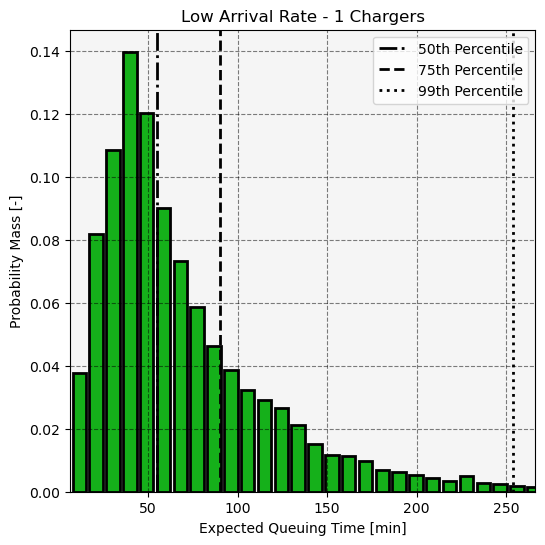

In [3]:
deep_reload(src)
from scipy.stats import norm, uniform, rv_histogram


shape = (100000, )
seed = 14285963

axes_kwargs = {
    'facecolor': 'whitesmoke',
    'xlabel': 'Expected Queuing Time [min]',
    'ylabel': 'Probability Mass [-]',
}

grid_kwargs = {
    'ls': 'dashed',
    'color': 'k',
    'alpha': .5,
}

legend_kwargs = {
    'loc': 1,
}

bar_kwargs = {
    'color': 'xkcd:green',
    'ec': 'k',
    'lw': 2,
}

fig, ax = plt.subplots(
    1, 1, figsize = (6, 6), squeeze = False, gridspec_kw = {'hspace': .35}
)

arrival_dist = uniform(loc = 600, scale = 3600)

service_dist = norm(loc = 60 * 3.6e6 / 80e3, scale = 15 * 3.6e6 / 80e3)

n_servicers = 1

qtd = src.rng.Queuing_Time_Distribution(
    arrival_dist, service_dist, n_servicers, seed = seed
)

qte = qtd(size = shape)

plot_histogram(qte / 60, ax[0, 0], **bar_kwargs)
ax[0, 0].set_title('Low Arrival Rate - 1 Chargers')

_ = [ax.set(**axes_kwargs) for ax in ax for ax in ax]
_ = [ax.grid(**grid_kwargs) for ax in ax for ax in ax]
_ = [ax.legend(**legend_kwargs) for ax in ax for ax in ax]

In [9]:
# Generating random graph
deep_reload(src)

# Seed for replication
seed = np.random.randint(0, sys.maxsize)
seed = 758712061200539789
# print(seed)
rng = np.random.default_rng(seed)

# Numbers of nodes origins, destinations, and chargers
n_nodes = 100
n_origins = 1
n_destinations = 5
n_chargers = 15

# Graph parameters
scale = (1e6, 1e6) # graph scale [m]
link_bounds = (1e-6, np.inf) # Link distance boundaries [m]
reference_distance = 200e3 # Characteristic distance for link probability function [m]
link_speeds = [105 / 3.6] # Possible values for link speeds [m/s]

# Graph generation
graph = src.rng.random_graph(
    n_nodes,
    scale = scale,
    reference_distance = reference_distance,
    link_bounds = link_bounds,
    link_speeds = link_speeds,
    seed = seed,
    range_multiplier = 1
)

# Origins and Destinations
origin_nodes, destination_nodes = src.rng.random_origin_destination(
    graph, n_origins, n_destinations, seed = seed)

veh = src.routing.ConstrainedVehicle()

# Chargers to add to charger nodes
charge_price = .5
functions = {
    'time': lambda x: x.update(
        {'time': x['time'] + veh.capacity * (1 - x['soc']) / veh.rate / 3600}),
    'delay': lambda x: x.update(
        {'time': src.routing.add_simple(x['time'], qtd(size = veh.n_cases) / 3600)}),
    'price': lambda x: x.update(
        {'price': x['price'] + veh.capacity * (1 - x['soc']) * charge_price / 3.6e6}),
    'soc': lambda x: x.update({'soc': 1})
}

graph_nc = graph.copy()

# Adding to graph
graph, assigned_nodes = src.rng.random_attribute_assignment(
    graph, 'functions', [functions] * n_chargers, rng
)

In [10]:
deep_reload(src)

t0 = time.time()

all_pairs_expectations = veh.all_pairs(
    graph,
    nodes = [0, 5, 7, 8, 55, 66],
    progress_bar = {'disp': True, 'freq': 10}
)

time.time() - t0

 [--------------->] (6/6) 100.00%, 4.07 it/s, 1.72 s elapsed, 0.00 s remaining

1.719503402709961

In [11]:
all_pairs_expectations

{0: {0: 0,
  66: 2664.810411958574,
  55: 14062.78854673462,
  5: 20043.78414663953,
  8: 22729.861798035177,
  7: 29474.600661818833},
 5: {5: 0,
  8: 7282.335321431793,
  7: 9757.317234423132,
  55: 13713.429552318397,
  0: 19434.497829429085,
  66: 21545.232287776365},
 7: {7: 0,
  5: 9757.317234423132,
  8: 11094.349528008006,
  55: 21665.31186009404,
  0: 29474.507330663204,
  66: 31585.241789010477},
 8: {8: 0,
  5: 7282.335321431793,
  7: 11094.349528008006,
  55: 14920.310037537485,
  0: 21483.16329702045,
  66: 23593.89775536773},
 55: {55: 0,
  5: 13713.429552318397,
  0: 14062.78854673462,
  8: 14920.399706048993,
  66: 16625.493005355638,
  7: 21665.13856983265},
 66: {66: 0,
  0: 2664.810411958574,
  55: 16625.493005355638,
  5: 24067.43280263226,
  8: 24840.22272279182,
  7: 31584.96158657548}}

In [358]:
deep_reload(src)

veh = src.routing.Vehicle(n_cases = 1, cutoff = 400e3)

In [359]:
deep_reload(src)

t0 = time.time()

all_pairs_expectations = veh.all_pairs(
    graph_nc,
    # nodes = [0, 5, 7, 8, 55, 66],
    progress_bar = {'disp': True, 'freq': 10}
)

time.time() - t0

 [--------->] (100/100) 100.00%, 231.24 it/s, 0.44 s elapsed, 0.00 s remaining

0.437605619430542

In [432]:
deep_reload(src)

veh = src.routing.Vehicle(n_cases = 1, cutoff = 400e3)

t0 = time.time()

path_expectations, path_values, _ = veh.routes(graph_nc, [0])

time.time() - t0

0.005245208740234375

In [378]:
deep_reload(src)

weights = {
    "distance": 400e3,
    "time": np.inf
}

t0 = time.time()

dist, paths = src.dijkstra_simple.dijkstra(
    graph_nc, [0], weights = weights
)

time.time() - t0

0.0017278194427490234

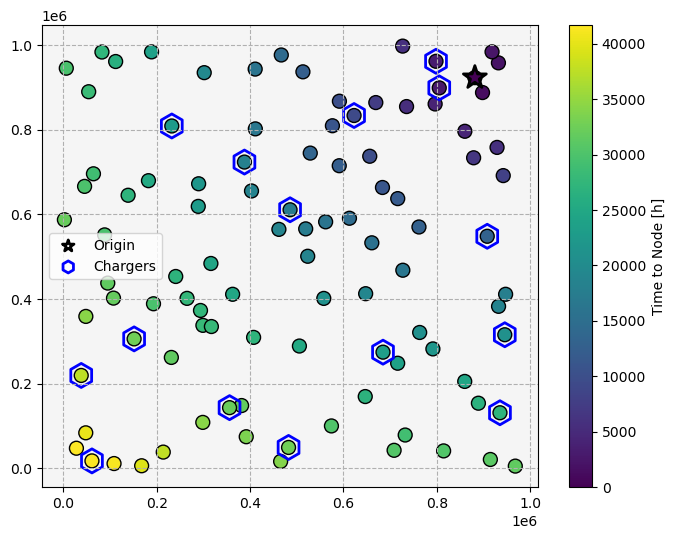

In [289]:
deep_reload(src)

path_values_avg = {}

for target, values in path_values.items():

    path_values_avg[target] = {}

    for key, val in values.items():

        path_values_avg[target][key] = src.utilities.super_quantile(val, 0, .01)

fig, ax  = plt.subplots(figsize = (8,6))

src.figures.dijkstra_output(
    graph, path_values_avg, origin_nodes, [], assigned_nodes, ax = ax,
    show_links = False, field = 'time')

_ = ax.set(**{'facecolor': 'whitesmoke'})
_ = ax.grid(ls = '--')

# fig.savefig('Document/figs/effect_of_charging_bev_c.png', bbox_inches = 'tight', dpi = 300)

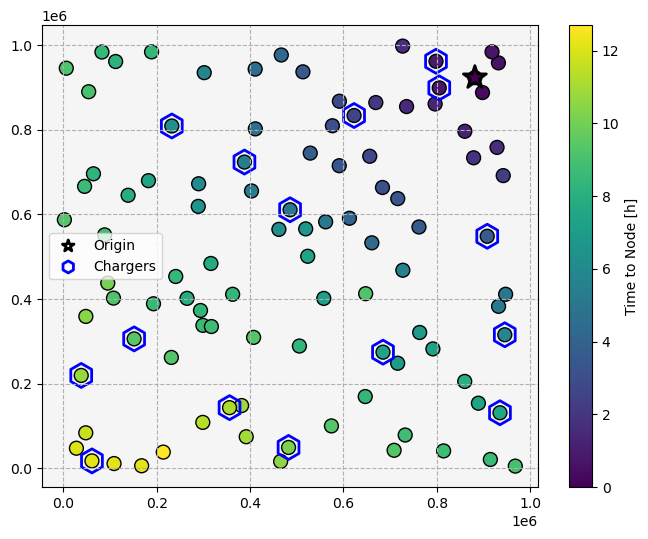

In [234]:
deep_reload(src)

path_values_avg = {}

for target, values in path_values.items():

    path_values_avg[target] = {}

    for key, val in values.items():

        path_values_avg[target][key] = src.utilities.super_quantile(val, 0, .01)

fig, ax  = plt.subplots(figsize = (8,6))

src.figures.dijkstra_output(
    graph, path_values_avg, origin_nodes, [], assigned_nodes, ax = ax,
    show_links = False, field = 'time_nc')

_ = ax.set(**{'facecolor': 'whitesmoke'})
_ = ax.grid(ls = '--')

# fig.savefig('Document/figs/effect_of_charging_bev_c.png', bbox_inches = 'tight', dpi = 300)

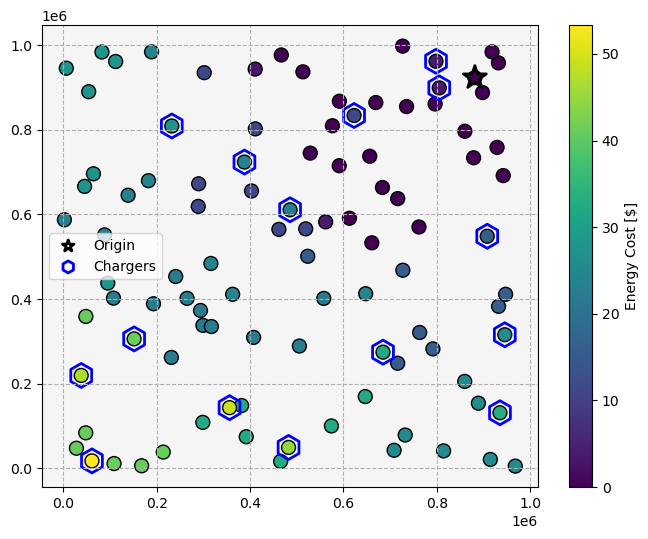

In [227]:
deep_reload(src)

path_values_avg = {}

for target, values in path_values.items():

    path_values_avg[target] = {}

    for key, val in values.items():

        path_values_avg[target][key] = src.utilities.super_quantile(val, 0, .01)

fig, ax  = plt.subplots(figsize = (8,6))

src.figures.dijkstra_output(
    graph, path_values_avg, origin_nodes, [], assigned_nodes, ax = ax,
    show_links = False, field = 'price', field_name = 'Energy Cost [$]')

_ = ax.set(**{'facecolor': 'whitesmoke'})
_ = ax.grid(ls = '--')

# fig.savefig('Document/figs/effect_of_charging_bev_c.png', bbox_inches = 'tight', dpi = 300)

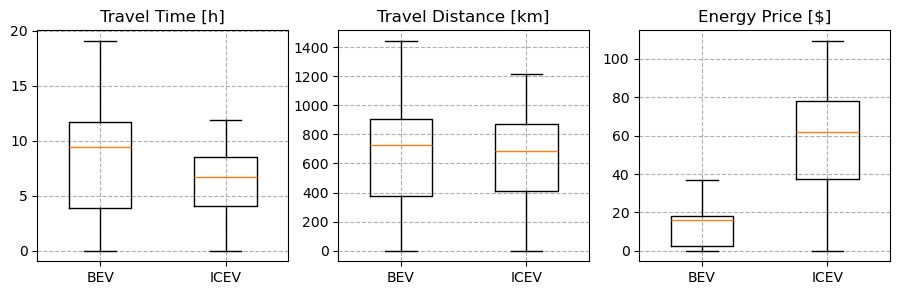

In [211]:
fig, ax = plt.subplots(1, 3, figsize = (11, 3))

kw = {
    'widths': .5,
    'labels': ['BEV', 'ICEV'],
}

data = [
    [v['time'] for v in path_values_avg.values()],
    [v['time'] for v in path_values_avg_icev.values()]
]

_ = ax[0].boxplot(data, **kw)
_ = ax[0].set(**{'title': 'Travel Time [h]'})

# data = [
#     [v['time_nc'] for v in path_values_avg.values()],
#     [v['time_nc'] for v in path_values_avg_icev.values()]
# ]

# _ = ax[1].boxplot(data)

data = [
    [v['distance'] for v in path_values_avg.values()],
    [v['distance'] for v in path_values_avg_icev.values()]
]

_ = ax[1].boxplot(data, **kw)
_ = ax[1].set(**{'title': 'Travel Distance [km]'})

data = [
    [v['price'] for v in path_values_avg.values()],
    [v['price'] for v in path_values_avg_icev.values()]
]

_ = ax[2].boxplot(data, **kw)
_ = ax[2].set(**{'title': 'Energy Price [$]'})

_ = [ax.grid(ls = '--') for ax in ax]

fig.savefig('Document/figs/routes_boxplots.png', bbox_inches = 'tight', dpi = 300)